# Notebook 3 : interprétabilité du modèle
---

Nous nous intéressons dans ce notebook à rendre intelligibles, c'est-à-dire compréhensible par un humain, le modèle Random Forest créé dans le cadre de ce projet.
Pour cela, nous allons utiliser plusieurs méthodes :
- la *Mean Decrease Impurity Importance* (MDI)
- la *Permutation Importance*
- le *Tree Interpreter*

Ces méthodes sont globales dans le sens où elles servent à expliquer des résultats à l'échelle du modèle (par opposition à l'échelle globale qui explique les résultats d'une prédiction en particulier)

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from eli5.sklearn.permutation_importance import PermutationImportance
from treeinterpreter import treeinterpreter
import matplotlib.pyplot as plt

import src.config.column_names as col
import src.config.base as base
from src.infrastructure.build_dataset import DataBuilderFactory, DataMerger
from src.domain.cleaning import MissingValueTreatment
from src.domain.build_features import feature_engineering_transformer
from interpretability_utilities import plot_features_importance 
from interpretability_utilities import plot_observation_contribution
from interpretability_utilities import plot_scores

In [2]:
from interpretability_utilities import compute_train_test_query_performances

In [3]:
from interpretability_utilities import compute_performances_from_y_pred

In [4]:
from warnings import simplefilter
from pandas.core.common import SettingWithCopyWarning

# Ignorer les warnings pour améliorer la lisibilité
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=SettingWithCopyWarning)

# 1. Chargement des données

In [5]:
# Build datasets

client_builder = DataBuilderFactory(base.TRAIN_CLIENT_DATA_PATH, base.config_client_data, base.ALL_CLIENT_DATA_TRANSLATION)
client_data = client_builder.transform('client')

eco_builder = DataBuilderFactory(base.TRAIN_ECO_DATA_PATH, base.config_eco_data)
eco_data = eco_builder.transform('eco')

# Merging files to final dataset
X, y = DataMerger(client_data, eco_data, col.MERGER_FIELD).transform()
y = y.eq('Yes').astype(int)

========== Processing client data ==========
- Casting types.
- Translating French terms to English.
- Dropping rows with too many missing values.
- Correcting erroneous entries.
========== Processing eco data ==========
- Casting types.
- Translating French terms to English.
- Dropping rows with too many missing values.
- Imputing missing data.
========== Merging datasets ==========
========== Separating target from explanatory variables ==========


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=base.SEED)

In [7]:
column_names = ['SOLDE', 'NB_CONTACTS_CAMPAGNE_EN_COURS', 'NB_CONTACTs_CAMPAGNE_EN_COURS', 'ETUDES_SUPERIEURE', 'ETUDES_SECONDAIRES', 
                'A_PRET_IMMO', 'A_PRET_PERSO', 'A_FAIT_DEFAULT', 'EST_RETRAITE', 'SUCCES_DERNIERE_CAMPAGNE', 'EST_CELIBATAIRE',
               'SUP_25_ANS', 'SUP_60_ANS', 'AGE', 'DATE_DERNIER_CONTACT', 'A_UN_PRET', 'NB_JOURS_DEPUIS_DERNIER_CONTACT','TAUX_EMPLOI',
                'INDICE_PRIX_CONSO', 'INDICE_CONFIANCE_CONSO']

# 2. Chargement du modèle 

In [8]:
# Chargement de la pipeline
pipeline = pickle.load(open(base.SAVED_MODEL_PATH, "rb"))

# Extraction du classifieur
clf = pipeline.best_estimator_.named_steps['rf_clf']

# Extraction des étapes de pre-processing (imputation et feature engineering)
transfo_pipeline = pipeline.best_estimator_[:2]

In [9]:
# Transformation des datasets d'entrainement et de test
X_train_transformed = transfo_pipeline.fit_transform(X_train, y_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=column_names, index= X_train.index)

X_test_transformed = transfo_pipeline.fit_transform(X_test, y_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_names, index= X_test.index)

In [10]:
print(f'Il y a {X_train_transformed.shape[1]} variables après le feature engineering.\n')
print('Les variables sont les suivantes :')
print(column_names)

Il y a 20 variables après le feature engineering.

Les variables sont les suivantes :
['SOLDE', 'NB_CONTACTS_CAMPAGNE_EN_COURS', 'NB_CONTACTs_CAMPAGNE_EN_COURS', 'ETUDES_SUPERIEURE', 'ETUDES_SECONDAIRES', 'A_PRET_IMMO', 'A_PRET_PERSO', 'A_FAIT_DEFAULT', 'EST_RETRAITE', 'SUCCES_DERNIERE_CAMPAGNE', 'EST_CELIBATAIRE', 'SUP_25_ANS', 'SUP_60_ANS', 'AGE', 'DATE_DERNIER_CONTACT', 'A_UN_PRET', 'NB_JOURS_DEPUIS_DERNIER_CONTACT', 'TAUX_EMPLOI', 'INDICE_PRIX_CONSO', 'INDICE_CONFIANCE_CONSO']


# 3. Importance des variables

## a. MDI (Mean Decrease Impurity Importance)

La MDI (Mean Decrease Impurity Importance), ou *feature importance*, nous renseigne sur les variables ayant eu le plus de poids dans l'entrainement du modèle. Précisément, la MDI correspond à la diminution de l'impureté des noeuds de l'arbre. Ce critère est ensuite pondérer par le nombre d'arbres de la forêt aléatoire.

In [11]:
importances = clf.feature_importances_

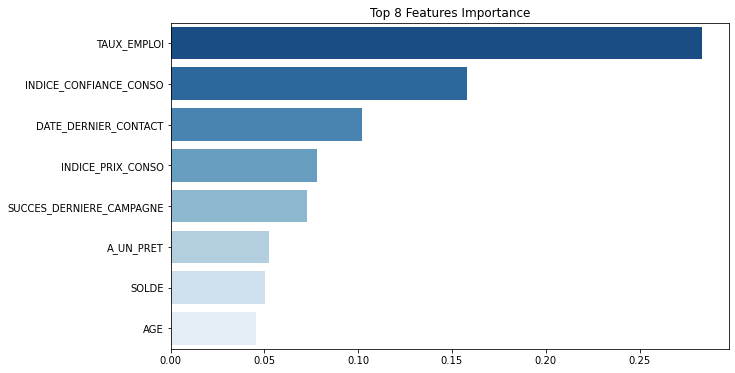

In [12]:
plot_features_importance(X_train_transformed,importances, 8)

La MDI nous montre que parmi les variables les plus importantes pour prédire si le client va souscrire au produit, les données socio-économiques ont une place très importante, en particulier le taux d'emploi et l'indice de confiance des consommateurs. La date de dernier contact avec le client pèse aussi significativement dans la balance.

## b. Permutation importance

La *permutation importance* (ou *Mean Decrease Accuracy Importance*) est une autre méthode utilisée pour déterminer les variables ayant eu le plus de poids dans la construction des arbres de décision de la forêt aléatoire.

Cette méthode calcule l'importance des variables en mesurant comment le score choisi (accuracy, recall,...) décroît quand cette variable n'est pas disponible. Cela montre donc à quel point la variable est précieuse, d'où son importance.

permutation_imp = PermutationImportance(clf, scoring='average_precision', n_iter=20, random_state=42, cv='prefit', refit=False)

permutation_imp.fit(X_test_transformed, y_test)

plot_features_importance(data=X_test_transformed, importances=permutation_imp.feature_importances_, n_feat=8)

Cette méthode montre également que les variables de type socio-économiques ont un poids plus important que les autres variables.

On note ici que la variable WAS_LAST_CAMPAIGN_SUCCESS (indicatrice valant 1 si la campagne précédente avait été un succès) est importante par rapport aux autres.

# 4. Tree interpreter

La méthode de *Tree interpreter* fonctionne d'une autre manière : chaque prédiction (feuille de l'arbre, *leaf node*) est décomposée en fonction des contributions des variables (les noeuds) qui mènent à elle. Si une variable n'intervient pas dans le chemin vers la prédiction, cela signifie que cette variable n'a pas été utile, sa contribution est donc nulle. Les contributions sont donc calculées en local (prédiction par prédiction).

Pour une forêt aléatoire, les contributions correspondent aux moyennes des contributions obtenues pour chacun des arbres.

Puis, pour obtenir l'importance de chaque variable à l'échelle globale du modèle, on fait la moyenne des contributions.  

In [13]:
predictions, bias, contributions = treeinterpreter.predict(clf, X_test_transformed)

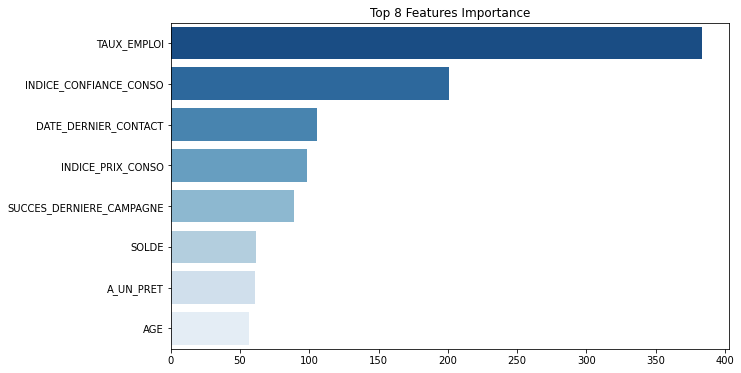

In [14]:
tree_interpreter_importances = contributions[:, :, 0].sum(axis=0)
plot_features_importance(data=X_test_transformed, importances=tree_interpreter_importances, n_feat=8)

Nous voyons ici aussi que les variables socio-économiques jouent un grand rôle dans la prédiction, et en particulier le taux d'emploi  qui arrive en 1ère position pour chaque méthode. C'est aussi le cas pour LAST_CONTACT_DATE dont l'importance reste forte quelle que soit la méthode utilisée.

# 5. Skope rules

In [15]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

In [16]:
f_predict = lambda x: clf.predict_proba(x)[:,1]

In [17]:
skope_rules_clf = SkopeRules(feature_names=X_train_transformed.columns, random_state=21, n_estimators=50,
                             #recall_min=0.05, precision_min=0.9, 
                             max_samples=0.5,
                             max_depth_duplication=2, max_depth=3)
skope_rules_clf.fit(X_train_transformed, y_train)

SkopeRules(feature_names=Index(['BALANCE', 'NB_CONTACT_CURRENT_CAMPAIGN', 'NB_CONTACT_LAST_CAMPAIGN',
       'EDUCATION??', 'EDUCATION_SECONDARY', 'HAS_HOUSING_LOAN',
       'HAS_PERSO_LOAN', 'HAS_DEFAULT', 'IS_RETIRED',
       'WAS_LAST_CAMPAIGN_SUCCESS', 'IS_SINGLE', 'SUP_25_YEARS_OLD',
       'SUP_60_YEARS_OLD', 'AGE', 'LAST_CONTACT_DATE', 'HAS_LOAN',
       'NB_DAYS_LAST_CONTACT', 'IDX_EMPLOYMENT_RATE', 'IDX_CONSUMER_PRICE',
       'IDX_CONSUMER_CONFIDENCE'],
      dtype='object'),
           max_depth_duplication=2, max_samples=0.5, n_estimators=50,
           random_state=21)

In [18]:
skope_rules_scoring = skope_rules_clf.score_top_rules(X_test_transformed)
random_forest_scoring = f_predict(X_test_transformed)

In [19]:
n_rules = len(skope_rules_clf.rules_)
print(f'{n_rules} rules have been built with SkopeRules.')

6 rules have been built with SkopeRules.


In [20]:
rules = skope_rules_clf.rules_

for rule in rules:
    print(rule[0] + '\n')

NB_CONTACT_CURRENT_CAMPAIGN <= 0.4333333373069763 and IDX_CONSUMER_CONFIDENCE > -0.09007656387984753 and WAS_LAST_CAMPAIGN_SUCCESS > 0.5

IDX_CONSUMER_CONFIDENCE <= 1.4323466420173645 and IDX_CONSUMER_CONFIDENCE > -0.09007656387984753 and WAS_LAST_CAMPAIGN_SUCCESS > 0.5

IDX_EMPLOYMENT_RATE <= -0.9621529579162598 and IDX_CONSUMER_PRICE <= -0.3809826448559761 and WAS_LAST_CAMPAIGN_SUCCESS > 0.5

IDX_CONSUMER_PRICE > -0.3809826448559761 and NB_CONTACT_LAST_CAMPAIGN <= 0.9666666686534882 and WAS_LAST_CAMPAIGN_SUCCESS > 0.5

IDX_CONSUMER_PRICE > -0.4230582192540169 and IDX_CONSUMER_CONFIDENCE > 1.1177124977111816 and WAS_LAST_CAMPAIGN_SUCCESS <= 0.5

IDX_CONSUMER_CONFIDENCE <= 1.3308517932891846 and IDX_CONSUMER_CONFIDENCE > 1.1177124977111816 and WAS_LAST_CAMPAIGN_SUCCESS <= 0.5



Résultats du modèle

In [21]:
for i in range(n_rules):
    print(f'Rule {i + 1}:')
    display(compute_train_test_query_performances(X_train_transformed, y_train,
                                                  X_test_transformed, y_test,
                                                  skope_rules_clf.rules_[i][0]))

Rule 1:


,precision,recall
train_set,0.723380,0.148739
test_set,0.752101,0.170314


Rule 2:


,precision,recall
train_set,0.775665,0.097097
test_set,0.765517,0.105614


Rule 3:


,precision,recall
train_set,0.576023,0.093765
test_set,0.672515,0.109420


Rule 4:


,precision,recall
train_set,0.790323,0.081628
test_set,0.783333,0.089439


Rule 5:


,precision,recall
train_set,0.500000,0.032128
test_set,0.509804,0.024738


Rule 6:


,precision,recall
train_set,0.500000,0.032128
test_set,0.509804,0.024738


In [22]:
%matplotlib inline

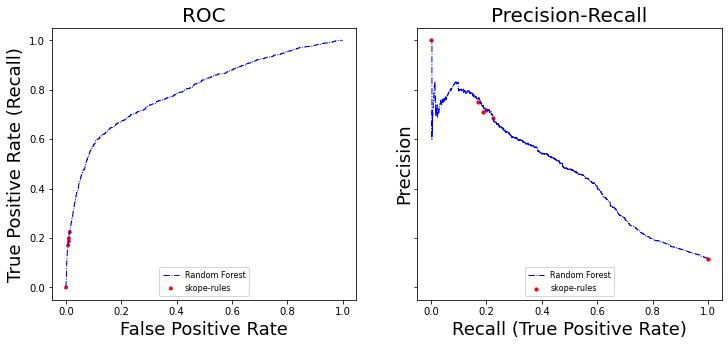

In [23]:
plot_scores(y_test, scores_with_line=[random_forest_scoring], scores_with_points=[skope_rules_scoring])

In [24]:
n_rule_chosen = 2
y_pred = skope_rules_clf.predict_top_rules(X_test_transformed, n_rule_chosen)

print(f'The performances reached with {n_rule_chosen} discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

The performances reached with 2 discovered rules are the following:


,precision,recall
test_set,0.752101,0.170314
